In [1]:
# !pip install matplotlib

In [92]:
# import import_ipynb
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers



In [93]:
from tensorflow.keras import layers
from tensorflow.keras import losses

In [94]:
from collections import Counter

In [95]:
# !pip install pandas

In [96]:
import pandas as pd
import numpy as np

In [97]:
# !pip install sklearn

In [98]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [99]:
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [100]:
# pip install pydot

In [101]:
import pydot
import json

In [102]:
print(tf.__version__)

2.15.0


In [103]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text):
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))])

    return text2.lower()

In [123]:
train_data= pd.read_csv("/content/final_train_dataset.csv")
columns_to_keep = ['DATE', 'HEADLINE', 'TICKER', 'COMPANY NAME', 'trend']

# Select only the desired columns
train_data = train_data[columns_to_keep]

train_data.dropna(axis = 0, how ='any',inplace=True)
train_data['Num_words_text'] = train_data['HEADLINE'].apply(lambda x:len(str(x).split()))
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['trend'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['HEADLINE'] = train_data['HEADLINE'].apply(remove_emoji)
train_data['HEADLINE'] = train_data['HEADLINE'].apply(remove_url)
train_data['HEADLINE'] = train_data['HEADLINE'].apply(clean_text)


test_data= pd.read_csv("final_dataset.csv")
test_data = test_data[columns_to_keep]

test_data.dropna(axis = 0, how ='any',inplace=True)
test_data['Num_words_text'] = test_data['HEADLINE'].apply(lambda x:len(str(x).split()))

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['trend'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['HEADLINE'] = test_data['HEADLINE'].apply(remove_emoji)
test_data['HEADLINE'] = test_data['HEADLINE'].apply(remove_url)
test_data['HEADLINE'] = test_data['HEADLINE'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

-------Train data--------
trend
bullish    367
bearish    275
unknown     22
Name: count, dtype: int64
664
-------------------------
-------Test data--------
trend
bullish    75
bearish    69
unknown     5
Name: count, dtype: int64
149
-------------------------
Train Max Sentence Length :56
Test Max Sentence Length :56


In [124]:
train_data.head()


DATE                                           HEADLINE    TICKER  \
0  2022-08-22  ftse semi annual review key changes migration ...      SAIL   
1  2022-08-22  tcs bags order from absa corporate investment ...       TCS   
2  2022-08-22            wins order the range ‚Çπ25005000 from ioc       IOC   
3  2022-08-22  gillette india ebitda 11b rupees 523m yoy ebit...  GILLETTE   
4  2022-08-22      rbl bank approves raising via debt securities       RBL   

                        COMPANY NAME    trend  Num_words_text  
0   Steel Authority of India Limited  bullish              25  
1  Tata Consultancy Services Limited  bearish               9  
2     Indian Oil Corporation Limited  bearish              11  
3             Gillette India Limited  bearish              21  
4          Rane Brake Lining Limited  bearish              12

In [125]:
test_data.head()

DATE                                           HEADLINE TICKER  \
0  2023-07-24  basf reports earnings net profit down ‚Çπ1127 ‚Çπ1...   BASF   
1  2023-07-24  pnb housing finance reports earnings net profi...    PNB   
2  2023-07-24  idbi bank reports earnings profit ‚Çπ12242 ‚Çπ7564...   IDBI   
3  2023-07-24  srf reports numbers chemicals segment revenue ...    SRF   
4  2023-07-25  itc extends decline down more than after cos b...    ITC   

           COMPANY NAME    trend  Num_words_text  
0    BASF India Limited  bearish              46  
1  Punjab National Bank  bearish              29  
2     IDBI Bank Limited  bearish              43  
3           SRF Limited  bullish              37  
4           ITC Limited  bullish              17

In [126]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['HEADLINE'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 1, 42, 1]]


In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['HEADLINE'].tolist(),\
                                                      train_data['trend'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['trend'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = tokenizer.texts_to_sequences(X_train)
x_valid = tokenizer.texts_to_sequences(X_valid)
x_test  = tokenizer.texts_to_sequences(test_data['HEADLINE'].tolist())



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
# test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:597
Class distributionCounter({'bullish': 330, 'bearish': 247, 'unknown': 20})
Valid data len:67
Class distributionCounter({'bullish': 37, 'bearish': 28, 'unknown': 2})
[  37 1939   46 1940   33 1941  779 1942  297 1943 1944 1945 1946 1947
  502   20 1948  982 1949   27   33 1950  627 1951    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [128]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['bullish', 'bearish', 'bearish', 'bullish', 'bearish', 'bearish', 'bearish', 'bullish', 'bullish', 'bullish']
Text to number
[1 0 0 1 0 0 0 1 1 1]
Number to category
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [129]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
# print('======Test dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==3:
#         break

======Train dataset ====
tf.Tensor(
[  37 1939   46 1940   33 1941  779 1942  297 1943 1944 1945 1946 1947
  502   20 1948  982 1949   27   33 1950  627 1951    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  49   20   88  270  505  506  404 2028  434   24 2029    3   44   15
   17    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[ 274    7    6   10    8    4 2456 2457    2    9    4 2458 2459    2
   11    4 2460 2461    2   13    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(
[ 105  668 2719 2720  300  289  660    3 2721  289    3  229 

In [135]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))




model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 64)            1280064   
                                                                 
 conv1d_7 (Conv1D)           (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1305155 (4.98 MB)
Trainable params: 1305155 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [136]:
# pip install pydotplus

In [137]:
# pip install graphviz

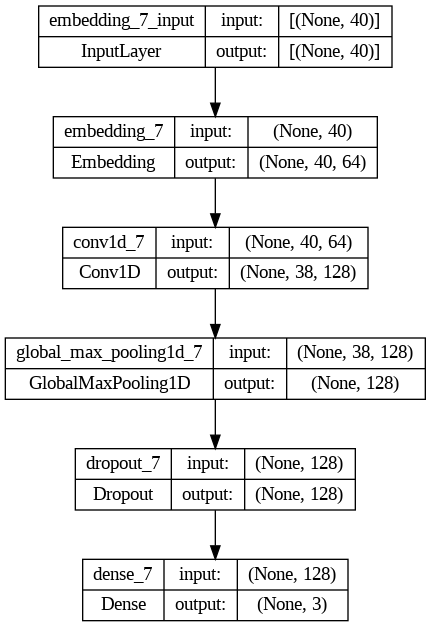

In [138]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


lets train

In [139]:
epochs = 8
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(32),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(32),
                    verbose=1)

Epoch 1/8
19/19 [==============================] - 3s 57ms/step - loss: 1.4754 - categorical_accuracy: 0.5343 - val_loss: 1.2722 - val_categorical_accuracy: 0.5522
Epoch 2/8
19/19 [==============================] - 1s 36ms/step - loss: 1.1272 - categorical_accuracy: 0.5628 - val_loss: 1.0156 - val_categorical_accuracy: 0.5522
Epoch 3/8
19/19 [==============================] - 1s 32ms/step - loss: 0.9330 - categorical_accuracy: 0.5628 - val_loss: 0.9043 - val_categorical_accuracy: 0.5522
Epoch 4/8
19/19 [==============================] - 1s 32ms/step - loss: 0.8645 - categorical_accuracy: 0.6265 - val_loss: 0.8767 - val_categorical_accuracy: 0.6119
Epoch 5/8
19/19 [==============================] - 1s 33ms/step - loss: 0.8384 - categorical_accuracy: 0.6482 - val_loss: 0.8710 - val_categorical_accuracy: 0.5821
Epoch 6/8
19/19 [==============================] - 1s 33ms/step - loss: 0.7888 - categorical_accuracy: 0.7136 - val_loss: 0.8625 - val_categorical_accuracy: 0.5970
Epoch 7/8
19/19 

In [140]:
history.history

{'loss': [1.4754376411437988,
  1.1271830797195435,
  0.9329711198806763,
  0.8644745349884033,
  0.8383764624595642,
  0.7888455986976624,
  0.7504575252532959,
  0.6937466263771057],
 'categorical_accuracy': [0.5343383550643921,
  0.5628140568733215,
  0.5628140568733215,
  0.6264656782150269,
  0.6482412219047546,
  0.713567852973938,
  0.7906197905540466,
  0.8324958086013794],
 'val_loss': [1.2722374200820923,
  1.0156149864196777,
  0.9042823910713196,
  0.8766766786575317,
  0.8710077404975891,
  0.8625469207763672,
  0.8555536866188049,
  0.8519280552864075],
 'val_categorical_accuracy': [0.5522388219833374,
  0.5522388219833374,
  0.5522388219833374,
  0.611940324306488,
  0.5820895433425903,
  0.5970149040222168,
  0.6567164063453674,
  0.641791045665741]}

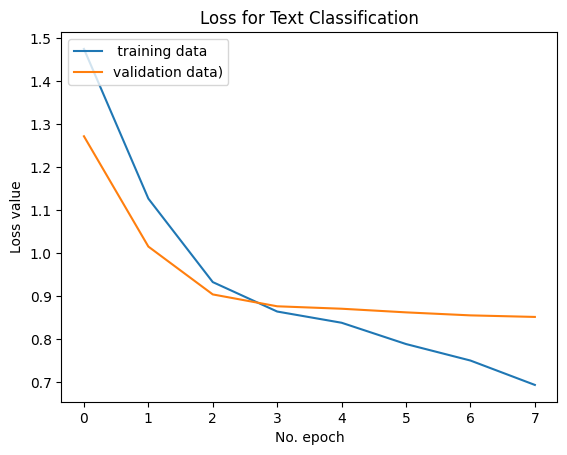

In [141]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

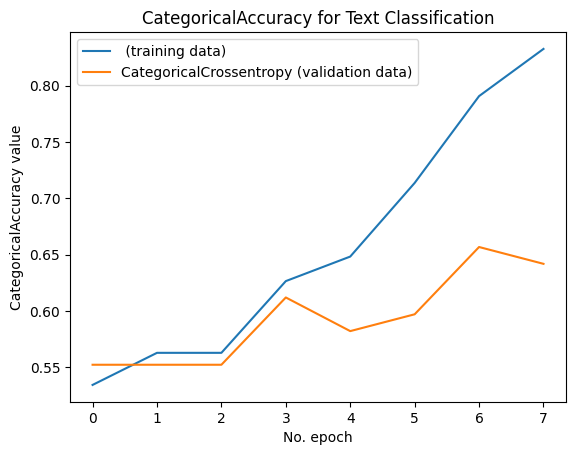

In [142]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [143]:
model.save('cnnmodel')
json_string = tokenizer.to_json()

In [144]:
import json
with open('tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [145]:
new_model = tf.keras.models.load_model('cnnmodel')
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 64)            1280064   
                                                                 
 conv1d_7 (Conv1D)           (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1305155 (4.98 MB)
Trainable params: 1305155 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [146]:
with open('C:\\Users\\HOME\\Desktop\\New Project\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HOME\\Desktop\\New Project\\tokenizer.json'

In [147]:
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
5/5 [==============================] - 0s 5ms/step
[[3.2578294  2.1818202  0.        ]
 [2.8255618  2.482756   0.        ]
 [2.3997433  2.7455776  0.        ]
 [2.3546665  2.875189   0.        ]
 [1.8390025  3.1138434  0.        ]
 [1.7917022  3.107385   0.        ]
 [1.8966964  3.0268009  0.        ]
 [2.1372526  2.8129766  0.        ]
 [2.164357   1.9629308  0.        ]
 [2.527112   2.91088    0.        ]
 [1.8992077  3.0491002  0.        ]
 [1.9985214  3.1280725  0.        ]
 [1.927329   3.0493233  0.        ]
 [2.6412575  2.2192008  0.        ]
 [2.7843304  2.1329353  0.        ]
 [2.6078293  2.3767335  0.        ]
 [2.5599163  2.464321   0.        ]
 [1.8872073  2.9510965  0.        ]
 [2.3779485  3.051541   0.        ]
 [1.7307976  3.1422274  0.        ]
 [2.509939   2.932554   0.        ]
 [2.7323267  2.7521455  0.        ]
 [3.2045743  2.2420511  0.        ]
 [3.2353966  2.2139351  0.        ]
 [2.6815994  2.1967509  0.        ]
 [1.9482635 

In [148]:
test_data['pred_sentiment']= predict_results


In [149]:
# labels = [1,0]

# print(classification_report(pr,ytest,labels=labels))

In [150]:
predict_results

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0])

In [151]:
y_test

Unnamed: 0.2  Unnamed: 0   sno        DATE  \
0               0           0    14  2023-07-24   
1               1           1    15  2023-07-24   
2               2           2    18  2023-07-24   
3               3           3    20  2023-07-24   
4               4           4    37  2023-07-25   
..            ...         ...   ...         ...   
144           144         144  1668  2024-05-08   
145           145         145  1681  2024-05-09   
146           146         146  1689  2024-05-12   
147           147         147  1697  2024-05-12   
148           148         148  1701  2024-05-12   

                                              HEADLINE TICKER  \
0    BASF reports #Q1 earnings\n\n- Net profit down...   BASF   
1    PNB Housing Finance reports #Q1 earnings\n\n- ...    PNB   
2    IDBI Bank reports Q1 earnings\n\n- Profit up 6...   IDBI   
3    SRF reports #Q1 numbers\n\n-Chemicals segment ...    SRF   
4    ITC extends decline, down more than 3% after c...    ITC   
..                                                 ...    ...   
144  BSE reports #Q4 earnings\n\nCons net profit up...    BSE   
145  IOB reports #Q4 earningsüëá\n\n‚û°Ô∏èNet profit up 2...    IOB   
146  TCI Express reports #Q4 earningsüëá\n\n‚û°Ô∏èNet pro...    TCI   
147  ITDC Q4\n\n--Net Profit Up 68% At Rs 32.4 Cr V...   ITDC   
148  BEML reports #Q4 earningsüëá\n\n‚û°Ô∏èNet profit up ...   BEML   

                                      COMPANY NAME                    SECTOR  \
0                               BASF India Limited                 Chemicals   
1                             Punjab National Bank               Banks - PSU   
2                                IDBI Bank Limited               Banks - PSU   
3                                      SRF Limited               Diversified   
4                                      ITC Limited                       NaN   
..                                             ...                       ...   
144                                    BSE Limited                       NaN   
145                           Indian Overseas Bank               Banks - PSU   
146         Transport Corporation of India Limited                 Transport   
147  India Tourism Development Corporation Limited                       NaN   
148                                   BEML Limited  Infrastructure - General   

                    SUBSECTOR SERIES  ...        close       volume  \
0                   Chemicals     EQ  ...  2664.300049  2664.300049   
1                 Banks - PSU     EQ  ...    62.099998    62.099998   
2                 Banks - PSU     EQ  ...    57.900002    57.900002   
3                 Diversified     EQ  ...  2144.350098  2137.418701   
4                         NaN     EQ  ...   462.299988   455.608521   
..                        ...    ...  ...          ...          ...   
144                       NaN     EQ  ...  2819.399902  2819.399902   
145               Banks - PSU     EQ  ...    61.150002    61.150002   
146                 Transport     EQ  ...   872.750000   872.750000   
147                       NaN     EQ  ...   614.099976   614.099976   
148  Infrastructure - General     EQ  ...  3210.050049  3210.050049   

     adj close     avg High      avg low     avg open    avg close  \
0       145514  3142.210010  3171.810010  3105.050049  3152.239941   
1     56162634    75.350000    76.730001    74.220000    75.329999   
2     16707700    69.260001    70.050000    68.600000    69.120000   
3      1884393  2677.100000  2697.679980  2638.230029  2661.220020   
4     43534718   575.669995   582.850012   565.189996   573.520001   
..         ...          ...          ...          ...          ...   
144     554365  3417.900000  3447.879980  3340.960010  3394.339941   
145   19825867    78.660000    79.349998    76.080001    77.000002   
146      20390  1051.290002  1066.240002  1029.950000  1047.440002   
147      30644   769.120007   776.810010   745.410010   754.700012   
148   

In [152]:
y_test=pd.read_csv('final_dataset.csv')

In [153]:
y=y_test.trend.values

In [154]:
len(predict_results)

149

In [155]:
pr=predict_results
len(pr)

149

In [156]:
len(y)

149

In [157]:
ytest=[]
for i in range(len(pr)):
    if(y[i]=='bearish'):
        ytest.append(0)
    else:
        ytest.append(1)


In [158]:
res=0
for i in range(len(pr)):
    if(ytest[i]==pr[i]):
        res=res+1



In [159]:
res

123

In [160]:
capable = res/len(pr)
print ("No. of dataset can be predicted : ",capable)

No. of dataset can be predicted :  0.825503355704698


In [161]:
com=pd.read_csv('final_dataset.csv')

In [162]:
compound=com.compound_score.values

In [163]:
com_pre=[]
for i in range(len(compound)):
    if(compound[i]<0):
        com_pre.append(0)
    elif(compound[i]>0):
        com_pre.append(1)
    else:
        com_pre.append(-1)


In [164]:
total=0
resu=0
actual=0
for i in range(len(com_pre)):
    if(com_pre[i]==pr[i] and pr[i]==ytest[i]):
        resu=resu+1
        total=total+1
    elif(com_pre[i]==pr[i] and pr[i]!=ytest[i]):
        total=total+1
    # elif(com_pre[i]==pr[i] and com_pre[i]!=-1):
    #     total=total+1



In [167]:
total

54

In [166]:
print ("Accuray over the predicted data : ",resu/total)

Accuray over the predicted data :  0.8518518518518519


In [84]:
results = []
results.append(pr)
results.append(com_pre)
results.append(pred)
results.append(ytest)

NameError: name 'pred' is not defined

In [ ]:
import pandas as pd

In [ ]:
df=pd.DataFrame(test_data.HEADLINE.values,columns=['Headlines'])

In [ ]:
df['Neural Network prediction']=pr
df['Emperical Weight prediction']=com_pre
df['Predicted trend']=pr
df['Actual trend']=ytest

In [ ]:
df.head(50)

Headlines  \
0   government has far transferred lakh through di...   
1   prime minister narendra modi launches digital ...   
2   irdai increases penalty max life insurance max...   
3   gtpl hathway reports earnings consolidated √¢‚Äì¬∂...   
4   butterfly gandhimathi appliances reports earni...   
5   kesoram industries reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet ...   
6   avenue supermarts reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet p...   
7   ahluwalia contracts india secures order worth ...   
8   ganesh housing corporation reports earnings co...   
9   tvs motors updated that acquisition stake tran...   
10  jsw steel smartex sign mou explore lowemission...   
11  concor focus from business standard dipam call...   
12  sunteck realty update √¢‚Äì¬∂√Ø¬∏¬èpresales yoy √¢‚Äö¬π33...   
13  will pay irdai penalty but believe did nothing...   
14  thangamayil jewellery reports earnings √¢‚Äì¬∂√Ø¬∏¬èn...   
15  max fin focus irdai penalty the end regulatory...   
16  oriental hotels √¢‚Äì¬∂√Ø¬∏¬ènet profit loss yoy √¢‚Äì¬∂√Ø...   
17  bank maharashtra reports earnings √¢‚Äì¬∂√Ø¬∏¬è net p...   
18  thangamayil jewellery reports earnings √¢‚Äì¬∂√Ø¬∏¬èn...   
19  irb invit fund reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet prof...   
20  pvr sees wider than expected loss √¢‚Äö¬π71 revenu...   
21  indian omcs incur losses stagnant fuel prices ...   
22                gujarat govt cuts vat cng png price   
23  satluj jal vidyut nigam sjvn arm sjvn green en...   
24  tata coffee reports earnings consolidated √¢‚Äì¬∂√Ø...   
25  maharashtra seamless reports earnings √¢‚Äì¬∂√Ø¬∏¬ène...   
26  sources say ofi global fund sell shares zee en...   
27  rpg life sciences reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet p...   
28  zeeent book launched ofi global fund sell stak...   
29  can fin homes 2qwithcnbctv18 √¢‚Äì¬∂√Ø¬∏¬ènet profit ...   
30  adani transmission saw jump the number electri...   
31  adani transmission saw jump the number electri...   
32  adani transmission saw jump the number electri...   
33  adani transmission saw jump the number electri...   
34  during the quarter adani transmission sold uni...   
35  during the quarter adani transmission sold uni...   
36  during the quarter adani transmission sold uni...   
37  during the quarter adani transmission sold uni...   
38  concor julyseptember total cargo volumes yoy t...   
39    block deal alert invesco sell stake zee ent for   
40  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
41  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
42  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
43  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
44  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
45  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
46  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
47  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
48  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   
49  tata metaliks reports earnings √¢‚Äì¬∂√Ø¬∏¬ènet profi...   

    Neural Network prediction  Emperical Weight prediction  Predicted trend  \
0                           1                            1                1   
1                           0                           -1                0   
2                           0                            0                0   
3                           0                            1                0   
4                           0                            1                0   
5                           0                            0                0   
6                           0                            1                0   
7                           0                            1                0   
8                           1                            1                1   
9                           1                           -1                1   
10                          1                           -1                1   
11                 

In [ ]:
arr[0][0]

'government has far transferred lakh through direct benefit transfer another instalment kisan will transferred tomorrow says prime minister narendramodi'

In [ ]:
arr=np.array(df)

In [ ]:
for i in range(len(arr)):
    if(arr[0][0]==)

Headlines  \
0  government has far transferred lakh through di...   
1  prime minister narendra modi launches digital ...   
2  irdai increases penalty max life insurance max...   
3  gtpl hathway reports earnings consolidated √¢‚Äì¬∂...   
4  butterfly gandhimathi appliances reports earni...   

   Neural Network prediction  Emperical Weight prediction  
0                          1                            1  
1                          0                           -1  
2                          0                            0  
3                          0                            1  
4                          0                            1

In [ ]:
df.to_csv('resultsec.csv')